In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import glob
from scipy.signal import fftconvolve, convolve
from scipy.special import erfc
from scipy.optimize import curve_fit
from lmfit.models import Model, LorentzianModel, GaussianModel

In [5]:
path = r'data/4-15/unlocked' 
path2 = r'data/4-15/locked' 
file_pattern = 'data_*.csv'

all_files_unlocked = glob.glob(path + '/' + file_pattern)
all_files_locked = glob.glob(path2 + '/' + file_pattern)

all_df_unlocked = []

for f in all_files_unlocked:
    df = pd.read_csv(f, skiprows=5)
    all_df_unlocked.append(df)

all_df_locked = []

for f in all_files_locked:
    df = pd.read_csv(f, skiprows=5)
    all_df_locked.append(df)

(0.239, 0.241)

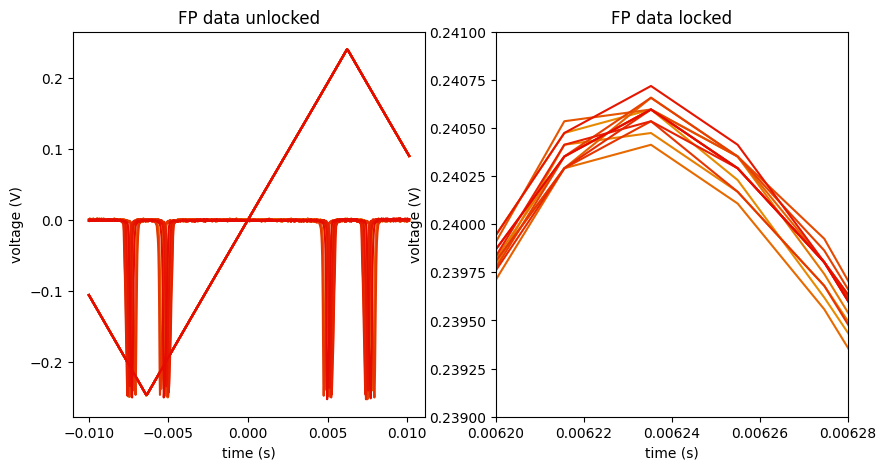

In [26]:
from matplotlib.colors import hsv_to_rgb

def generate_color(factor):
    hue = 0.1 - factor * 0.1  # Linearly interpolate from 0.1 to 0.0
    saturation = 1  # Full saturation for vivid colors
    value = 0.9  # Lower brightness for darker colors
    return hsv_to_rgb((hue, saturation, value))

fig, ax = plt.subplots(1,2, figsize=(10, 5))

for i, df in enumerate(all_df_unlocked):
    factor = i / len(all_df_unlocked)  # Normalize factor between 0 and 1
    color = generate_color(factor)
    ax[0].plot(df['time'], df['ch1'], label='ch1', color=color)
    ax[0].plot(df['time'], df['ch2']/20, label='ch2', color=color)
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('voltage (V)')
ax[0].set_title('FP data unlocked')
#ax[0].set_xlim(-0.0065, -0.004)
factor = 0
for i, df in enumerate(all_df_locked[:13]):
    factor = i / len(all_df_locked[:13])  # Normalize factor between 0 and 1
    color = generate_color(factor)
    ax[1].plot(df['time'], df['ch1'], label='ch1', color=color)
    ax[1].plot(df['time'], df['ch2']/20, label='ch2', color=color)
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('voltage (V)')
ax[1].set_title('FP data locked')
ax[1].set_xlim(0.0062, 0.00628)
ax[1].set_ylim(0.239, 0.241)

In [11]:
def gaussian(x, amplitude, center, sigma):
    return amplitude * np.exp(-0.5 * ((x - center) / sigma)**2)

def lorentzian2(x, amplitude, center, fwhm):
    """Normalized Lorentzian with independent parameters"""
    gamma = fwhm / 2.0
    return amplitude * (gamma**2) / ((x - center)**2 + gamma**2)

def fit_half_peak(x, y, amp_guess, center_guess, sigma_guess, buffer=0, peak='Gaussian', plot=True):
    min_y_i = np.argmin(y)
    y_cut = y[:min_y_i+buffer]
    x_cut = x[:min_y_i+buffer]
    time_range_hg = np.linspace(x_cut[0], x_cut[-1], 1000)
    if peak == 'Gaussian':
        popt, _ = curve_fit(gaussian, x_cut, y_cut, p0=[amp_guess, center_guess, sigma_guess])
        init_hg = gaussian(time_range_hg, amp_guess, center_guess, sigma_guess)
        fit_hg = gaussian(time_range_hg, *popt)
    elif peak == 'Lorentzian':
        popt, _ = curve_fit(lorentzian2, x_cut, y_cut, p0=[amp_guess, center_guess, sigma_guess])
        init_hg = lorentzian2(time_range_hg, amp_guess, center_guess, sigma_guess)
        fit_hg = lorentzian2(time_range_hg, *popt)
    else:
        raise ValueError("Invalid peak type. Choose 'Gaussian' or 'Lorentzian'.")
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(time_range_hg, fit_hg, label=f'half peak fit, mu={popt[1]:.5f}')
        plt.plot(time_range_hg, init_hg, label=f'half peak init, mu={center_guess:.5f}')
        plt.scatter(x, y, label='data')
        plt.ylabel('ch1 (V)')
        plt.xlabel('time (s)')
        plt.title(f'FP Peak Fit Half {peak}')
        plt.legend()
    return popt
    


In [9]:
def simple_expgauss(x, amp, center, sigma, exp_decay):
    lambd = 1 / exp_decay
    arg = (center + lambd * sigma**2 - x) / (sigma * np.sqrt(2))
    exponent = 0.5 * lambd * (2 * center + lambd * sigma**2 - 2 * x)
    
    return 0.5 * amp * lambd * np.exp(exponent) * erfc(arg)

def fit_expgauss(x, y, amp_guess, center_guess, sigma_guess, exp_decay_guess, plot=True):
    popt, _ = curve_fit(simple_expgauss, x, y, p0=[amp_guess, center_guess, sigma_guess, exp_decay_guess])
    time_range = np.linspace(x[0], x[-1], 1000)
    fit = simple_expgauss(time_range, *popt)
    init_fit = simple_expgauss(time_range, amp_guess, center_guess, sigma_guess, exp_decay_guess)
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(time_range, fit, label='fit')
        plt.plot(time_range, init_fit, label='init fit')
        plt.scatter(x,y, label='data')
        plt.xlabel('ch1 (V)')
        plt.ylabel('time (s)')
        plt.title('fp peak fit')
        plt.legend()
        print(popt)
    return popt

In [60]:
def triangle(x, center, slope, bias):
    return bias - slope *np.abs(x - center)

def fit_triangle(x, y, center_guess, slope_guess, bias_guess, plot=False):
    tri_model = Model(triangle, independent_vars=['x'])
    params_tri = tri_model.make_params(center=center_guess, slope=slope_guess, bias=bias_guess)
    tri_result = tri_model.fit(y, params_tri, x=x)
    if plot:
        plt.scatter(x, y, label='data')
        plt.plot(x, tri_result.best_fit, label='fit')
        plt.xlabel('ch1 (V)')
        plt.ylabel('time (s)')
        plt.title('fp peak fit')
       # plt.legend()
    return tri_result.params['center'].value


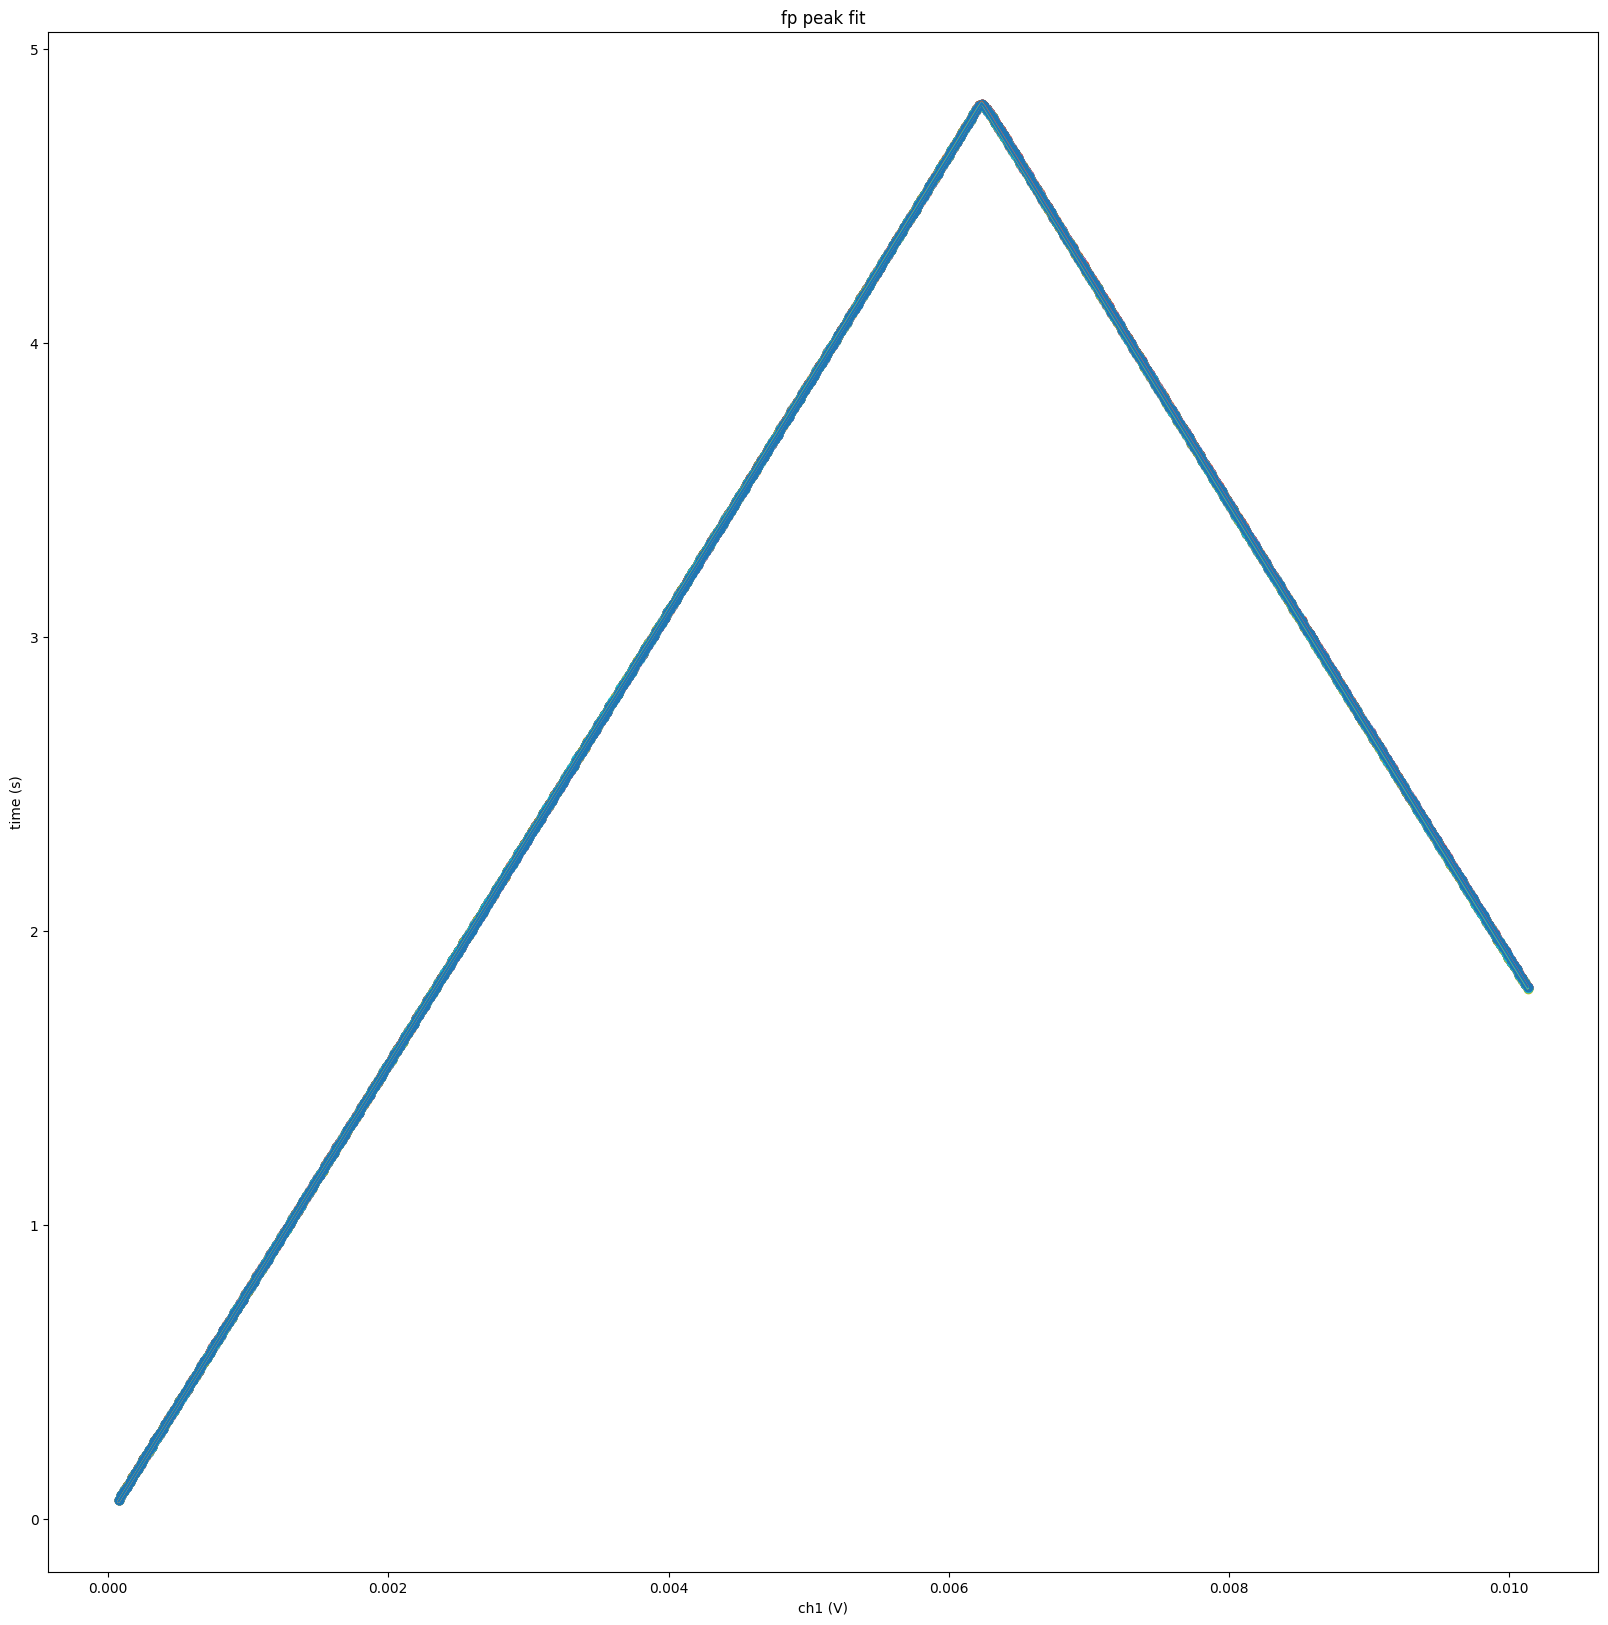

In [69]:
def calibrator(dfs, plot=True):
    tri_fits = []
    fig = plt.figure(figsize=(20,20))
    for df in dfs:
        time = df['time'].to_numpy()
        triangle_wave = df['ch2'].to_numpy()
        peak = df['ch1'].to_numpy()
        time_half = time[time.shape[0]//2:]
        triangle_wave_half = triangle_wave[time.shape[0]//2:]
        center = fit_triangle(time_half, triangle_wave_half, 0.006, 700, 5, plot=fig)
        tri_fits.append(center)
    # plt.xlim(0.0055, 0.007)
    # plt.ylim(4.3,4.823)
calibrat = calibrator(all_df_locked)

In [ ]:
nump = all_df_locked[0].to_numpy()
half_len = int(nump[:,0].shape[0]//2)
tri_x = nump[half_len:,2]
tri_y = nump[half_len:,1]


In [ ]:
tri_model = Model(triangle, independent_vars=['x'])
params_tri = tri_model.make_params(center=0.005, slope=700, bias=5)
tri_result = tri_model.fit(tri_y, params_tri, x=tri_x)